# Data Preprocessing

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.ticker as mticker

# --- Configuración de Matplotlib para usar LaTeX ---
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"], # O la fuente que prefieras (ej. 'Times New Roman')
})

Primero procedemos a cargar los datos en bruto 

In [2]:
data = pd.read_excel('../data/depresion.xlsx')

### Verificando missing values

In [3]:
nan_counts = data.isnull().sum()
total_records = len(data)

nan_counts = nan_counts[nan_counts > 0]
nan_percentages = (nan_counts / total_records) * 100
nan_percentages = nan_percentages.sort_values()
nan_counts = nan_counts[nan_percentages.index]

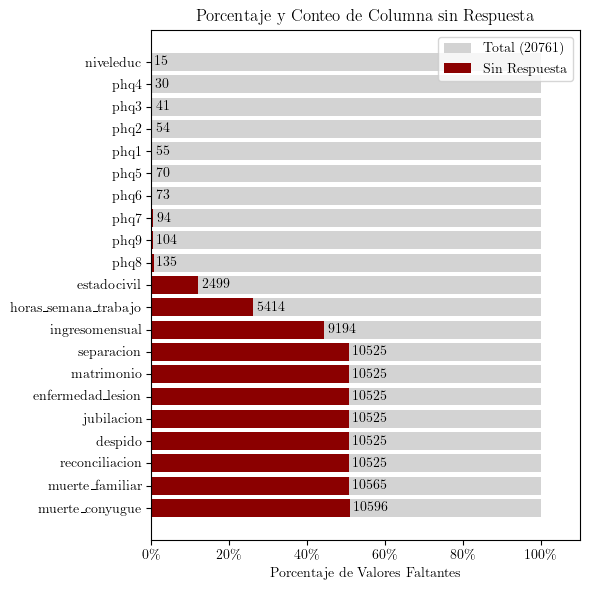

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))

y_labels = nan_percentages.index
y_pos = np.arange(len(y_labels))

# Barra del total (100%) al fondo
ax.barh(y_pos, [100] * len(y_pos), color='lightgrey', align='center', label='Total ({})'.format(total_records))

# Barra de los NaN (ancho según el porcentaje)
ax.barh(y_pos, nan_percentages, color='darkred', align='center', label='Sin Respuesta')

# --- 3. Añadir etiquetas con la cantidad de nans ---
# Itera sobre cada columna que tiene NaNs
for i, percentage in enumerate(nan_percentages):
    # El texto de la etiqueta es el CONTEO absoluto
    count_label = nan_counts.iloc[i]
    # Colocar el texto un poco a la derecha de la barra de porcentaje
    ax.text(percentage + 1, i, str(count_label), color='black', va='center', fontweight='bold')

# --- 4. Ajustes finales del gráfico ---
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.invert_yaxis()
ax.set_xlabel('Porcentaje de Valores Faltantes')
ax.set_title('Porcentaje y Conteo de Columna sin Respuesta')
ax.legend(loc='upper right')

# Formatear el eje X para que muestre el símbolo de porcentaje
ax.xaxis.set_major_formatter(mticker.PercentFormatter())
ax.set_xlim(0, 110) # Dejar espacio para la etiqueta del 100%

plt.tight_layout()
plt.savefig('../figures/missing_values.png', dpi=300)

### 

Podemos ver que todas las columnas tienen *missing values*. En lo que sigue, debemos considerar esto para el ajuste de nuestro modelo. 

#### Creando la variable `score PHQ-9`

Segun el cuestionario oficial, la suma de las 9 preguntas del cuestionario nos entregan el valor total sobre el cual se puede realizar un diagnostico 

<img src="../figures/PHQ_example.png" alt="Ejemplo del cuestionario PHQ" width="400"/>

De esta forma, partimos seleccionamos solo las columnas que tengan relacion con el Patient Health Questionnaire (PHQ) y sobre esta sub-tabla contamos la cantidad de items sin responder por paciente. Con esto logramos tener una idea de la magnitud de la omision.

In [5]:
nan_pp = data.iloc[:, 2:11].isna().sum(axis=1) # nan per person
nan_pp = nan_pp[nan_pp>0].value_counts().reset_index()
nan_pp.loc[-1] = [7, 0]
nan_pp= nan_pp.sort_values('index')

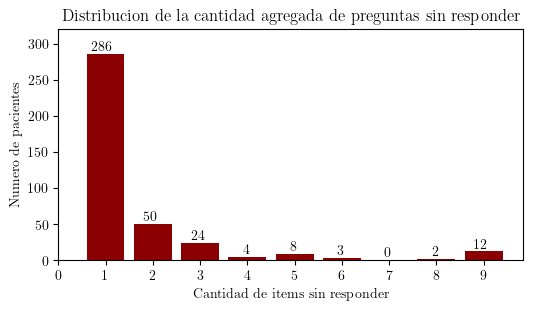

In [6]:
plt.figure(figsize=(6, 3), dpi=100)
plt.bar(nan_pp['index'], nan_pp['count'], color='darkred')

shift_x = [0.7, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8]
for i, value in enumerate(nan_pp['count'].values):
    plt.text(i+shift_x[i], value+5., value)
plt.xticks(np.arange(0, 10))
plt.ylim(0, 320)
plt.title('Distribucion de la cantidad agregada de preguntas sin responder')
plt.xlabel('Cantidad de items sin responder')
plt.ylabel('Numero de pacientes')
plt.savefig('../figures/missing_agregado.png', dpi=300,  bbox_inches='tight')
plt.show()


La mayor parte de las personas (286) solo dejo una pregunta sin respuesta. Dado que $\text{SPHQ}_i$, el Score PHQ-9 para paciente $i$-esimo, correpsonde a la suma de todas las columnas, 
$$\text{SPHQ}_i = \sum_{q=1}^{9} PQ(q)$$
un potencial proxy (en presencia de missing values) seria utilizar el promedio de las respuestas, 
 $$\hat{\text{SPHQ}_i} = \frac{1}{N}\sum_{q=1}^{9} PQ(q)$$
En principio esto es valido porque todas las preguntas valen lo mismo, entonces es un buen aproximador del score total. Sin embargo, esta aproximacion no será el score verdadero que la persona habría tenido si hubiera respondido todo. 

Si la razón por la que falta un dato no es completamente aleatoria (por ejemplo, quizás las personas más deprimidas tienden a saltarse preguntas específicas), este error de medición podría estar correlacionado con el verdadero nivel de depresión, lo que podría sesgar nuestros estimadores.

Por ahora, no se consideraran esas columnas.

In [7]:
nan_pp = data.iloc[:, 2:11].isna().sum(axis=1) # nan per person
clean_data = data[nan_pp==0].copy()
data.shape[0], data.shape[0] - clean_data.shape[0], round((data.shape[0] - clean_data.shape[0])/data.shape[0], 2)

(20761, 389, 0.02)

Ahora la cantidad de datos es 20372, lo cual equivale a 389 datos (~2% del total).


Sobre nuestro conjunto de datos "completo" (i.e., sin missing value en las columnas `phq-i`) procedemos a calcular el $\text{SPHQ}_i$ para cada paciente.

Segun la referencia oficial, cada pregunta puede ser respondida entre 4 opciones, donde: 
- 0: Nunca
- 1: Algunos dias
- 2: Mas de la mitad de los dias
- 3: Casi todos los dias

En nuestra tabla de datos hay 1 opcion mas (i.e., "todos los dias"). Esta opcion extra no se encuentra considerada en la bibliografia oficial.  
Para poder utilizar la referencia de clasificacion de diagnostico, se asumira que `Todos los dias = Casi todos los dias = 3`.

El diagnostico de scores esta determiando por, 
| Level of Depression Severity | PHQ-9 Score |
| :--- | :--- |
| Minimal | 1–4 |
| Mild | 5–9 |
| Moderate | 10–14 |
| Moderately severe | 15–19 |
| Severe | 20–27 |

*Fuente: Kroenke, Kurt, Robert L. Spitzer, and Janet BW Williams. "The PHQ‐9: validity of a brief depression severity measure." Journal of general internal medicine 16.9 (2001): 606-613.*


Reemplazamos estos valores en nuestra tabla 

In [8]:
to_change = {
    'Nunca': 0,
    'Algunos dias': 1,
    'Mas de la mitad de los dias': 2,
    'Casi todos los dias': 3,
    'Todos los dias': 3
}

phq_cols = ['phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'phq9']
phq_numeric = clean_data[phq_cols].replace(to_change)
new_data = clean_data.drop(columns=phq_cols)
new_data['phq_score'] = phq_numeric.sum(axis=1)

C:\Users\copper\AppData\Local\Temp\ipykernel_14936\3501504843.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  phq_numeric = clean_data[phq_cols].replace(to_change)


In [9]:
score_bins = [-1, 4, 9, 14, 19, 27]
numeric_labels = [0, 1, 2, 3, 4]
string_labels = ['Mínima', 'Leve', 'Moderada', 'Moderadamente Severa', 'Severa']

new_data['severity_category'] = pd.cut(new_data['phq_score'], bins=score_bins, labels=numeric_labels, right=True)
new_data['severity_label'] = pd.cut(new_data['phq_score'], bins=score_bins, labels=string_labels, right=True)

Finalmente, para el total de 20372 pacientes, la distribucion de etiquetas sobre la columna `phq_9` es,

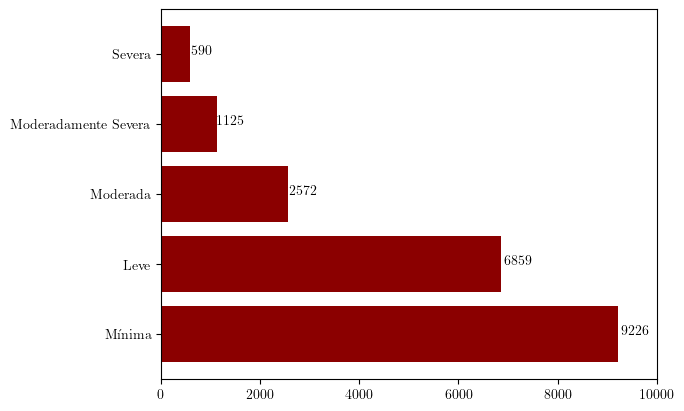

In [10]:
labels_count = new_data['severity_label'].value_counts().reset_index()

plt.figure()
plt.barh(labels_count['severity_label'], labels_count['count'], color='darkred')
shift_x = [50, 50, 20, 10, 10, 10]
for i, t in enumerate(labels_count['count']):
    plt.text(t+shift_x[i], i, '{}'.format(t))

plt.xlim(0, 10000)
plt.savefig('../figures/newdata.png', dpi=300,  bbox_inches='tight')
plt.show()

### Preparando las columnas para cada inciso 

In [69]:
control_vars     = ['edad', 'sexo', 'niveleduc', 'estadocivil']
cand_instrumento = ['muerte_conyugue', 'separacion', 'muerte_familiar', 'enfermedad_lesion', 'despido', 'reconciliacion'] # matrimonio
result_laborales = ['horas_semana_trabajo', 'ingresomensual']
paciente_ids     = ['id', 'ola']
dependiente_var  = ['phq_score', 'severity_category', 'severity_label']

### Parte 1: Modelo Probit  

In [77]:
def clean_for_nan(df, by):
    df_cp = df[~df[by].isna()].copy()
    return df_cp

In [92]:
nonan = clean_for_nan(new_data, by='horas_semana_trabajo')
for vc in control_vars:
    nonan = clean_for_nan(nonan, by=vc)
print('{}/{} - {:.2f}%'.format(nonan.shape[0], new_data.shape[0], nonan.shape[0]/new_data.shape[0]))

labor_cond = nonan['horas_semana_trabajo'] > 0.
nonan['trabaja'] = labor_cond.astype(int)
nonan = nonan[control_vars + dependiente_var + ['trabaja']]


14156/20372 - 0.69%


Se considero `horas_semana_trabajo > 0`  como criterio para definir si una persona trabaja o no. 

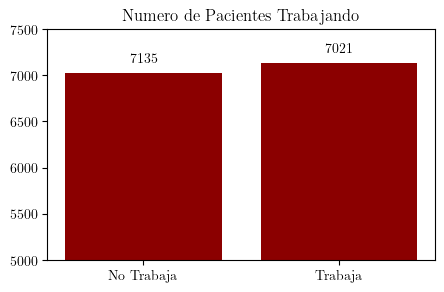

In [93]:
partial = nonan['trabaja'].value_counts().reset_index()
plt.figure(figsize=(5,3))
plt.bar(partial['trabaja'], partial['count'], color='darkred')
shift_y = [10, 230]
for i, v in enumerate(partial['count']):
    plt.text(i-0.07, v+shift_y[i], '{}'.format(v))

plt.xticks([0, 1], ['No Trabaja', 'Trabaja'])
plt.ylim(5000, 7500)
plt.title('Numero de Pacientes Trabajando')
plt.show()

In [99]:
nonan.to_csv('../data/p1.csv', index=False)